In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from mlxtend.preprocessing import TransactionEncoder
import random
from mlxtend.frequent_patterns import apriori
import pyfpgrowth
from format_rules import format_rules
#from server_association import server_association
from Server_Assign import server_association
from hourly_step_assign2 import hourly_step_output
from hourly_step_assign_test2 import hourly_step_test_output
#from apyori import apriori 

In [2]:
#load data
#df=pd.read_csv('df_test.csv')
client = boto3.client('s3')
obj = client.get_object(Bucket='manifolddata', Key='week1.csv')
df = pd.read_csv(BytesIO(obj['Body'].read()), low_memory=False)


df=df.iloc[:,[0,1,3,4,5,6,7,8]]
df.columns=['Date', 'Duration', 'Src_IP', 'Src_pt', 'Dst_IP', 'Dst_pt','Packets', 'Bytes']
#add an date column that is rounded to nearest hour, so we can use this as a timestep to see how frequently IP pairs occur in each timestep
df['Date']=pd.to_datetime(df['Date'], format="%Y-%m-%d %H:%M:%S.%f", errors = 'coerce')
df['date_hr']=pd.Series(df['Date']).dt.round("H")


In [3]:
#create a pair column, which is a touple of the src and dst IP, sorted. 
#It does not matter which call came first, we simply want to know which pair occurs most frequently.

df['pairs']=list(zip(df.Src_IP, df.Dst_IP))
df['pairs']=df['pairs'].apply(sorted)
df['pairs2']=tuple(df['pairs'])
#create a normalized latency column = duration/packets
df['norm_latency']=df['Duration']/df['Packets']

In [4]:
def convert_si_to_number(x):
    total_stars = 0
    if 'k' in x:
        if len(x) > 1:
            total_stars = float(x.replace('k', '')) * 1000 # convert k to a thousand
    elif 'M' in x:
        if len(x) > 1:
            total_stars = float(x.replace('M', '')) * 1000000 # convert M to a million
    elif 'B' in x:
        total_stars = float(x.replace('B', '')) * 1000000000 # convert B to a Billion
    else:
        total_stars = int(x) # Less than 1000
    return int(total_stars)

In [5]:
df.Bytes=df.Bytes.astype('str')
test_list=df.Bytes

[i for i, s in enumerate(test_list) if 'M' in s]#show where the M errors are happening

test_list= [convert_si_to_number(x) for x in test_list]
df.Bytes=test_list #bring it back into the dataframe


In [6]:
#add hour column, where it is a value 1-24, and repeats each day
df['hour']=None
df['hour']=pd.DatetimeIndex(df['Date']).hour


In [8]:
df.head()

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,norm_latency,hour
0,2017-08-02 00:00:00.419,0.003,192.168.210.55,44870,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.0015,0
1,2017-08-02 00:00:00.421,0.000,192.168.100.11,445,192.168.210.55,44870.0,1,108,2017-08-02,"[192.168.100.11, 192.168.210.55]","(192.168.100.11, 192.168.210.55)",0.0000,0
2,2017-08-02 00:00:02.593,0.004,192.168.220.47,55101,192.168.100.11,445.0,2,174,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.0020,0
3,2017-08-02 00:00:02.859,0.000,10000_34,443,192.168.210.54,59628.0,1,100,2017-08-02,"[10000_34, 192.168.210.54]","(10000_34, 192.168.210.54)",0.0000,0
4,2017-08-02 00:00:02.594,0.000,192.168.100.11,445,192.168.220.47,55101.0,1,108,2017-08-02,"[192.168.100.11, 192.168.220.47]","(192.168.100.11, 192.168.220.47)",0.0000,0


how many transactions do we have?

In [24]:
len(df)

8185992

## Implement Frequent Pattern (FP) - Growth algorithm

https://fp-growth.readthedocs.io/en/latest/usage.html

This algorithm
1. Counts occurence of items in dataset in 1st pass
2. Build FP-tree by inserting instances, and adds count to each instance based on the number of times it appears in the dataset. Those infrequent instances are dropped from the tree.

This allows the frequentest set to be generated organically, instead of creating a list of each itemset and checking if it does/does not pass minimum threshold (like Apriori algorithm)

#### Vocabulary
 - itemset = all items in 1 transaction
A "pattern" is a conjunction of items, or the unique itemset.
A "rule" X --> Y means if you buy X you are likely to buy Y, or in this case if X IP address is used Y IP address is likely also


#### Evaluation metrics include:

1. Support = how frequently it occurs. The number of transactions of that unique itemset / all transactions. In this case: number of times IP pair occurs/all requests

2. Confidence = how often rule is likely to be true. frequency of X and Y occuring/ frequency of X occuring in entire dataset. Conditional probability of Y given X. P(Ey|Ex)

3. Lift = How likely is item Y given item X occurs, controlling for how frequent Y occurs in the entire dataset. For rule X-->Y, lift = P(Y|X)/P(Y).
    Lift = 1 means X and Y are independent
    Lift >1 = X and Y are positively correlated
    Lift <1 = X and Y are negatively correlated

### This module does the following steps:
    
    1. Data manipulation, puts the dataframe in the correct form needed
    2. Frequent Pattern growth algorithm --> creates patterns and rules
    3. Merges in the latency and frequency information from the original data to prioritize the rules
    4. Assigns Apps to specific servers in order of prioritization 
    
The input to the module are:
    1. df = dataframe cleaned as outlined above (I did not put this in code in case different dataframes are used). The format should be:
    Date, Duration, Src_IP,	Src_pt,	Dst_IP,	Dst_pt,	Packets, Bytes,	date_hr, pairs, pairs2, norm_latency
    Although order does not really matter, as any variables are called by name.
    2. Percentile = minimum number of occurances you want a particular pair of apps to pass. If this value = 0.4, then any pair that's frequency is >= the 40th percentile of all pairs occuriing in the entire dataset will be used to create rules.
    3. confidence = minimum threshold that you want the rule to be true within the entire dataset. If this value = 0.7 we want to be sure that the rule is true 70% of the time.
    4. apps_server = how many apps can fit on a server. If this value = 20 you can fit 20 apps on a server before it is full and we move on to the next one.
    
     5. Outputs:
        1. the dataframe with all the assigned servers adjacent to each transaction
        2. the app assignment table
        3. summation of latency times for the entire data
        4. summation of latency times for the enitre data if the model were applied
        5. and the data if it were assigned to the servers as prescribed by the model
        6. average transaction latency (s)
        7. average transaction latency modeled (s)

##  Implement Frequentest paterns algorithm, and assign servers for each hour

Start with the highest rank IP pair, assign matching servers and then move on to the next highest rank pair until that server is full. This is a 'dumb' approach, but  it clearly assigns things based on priority and gets a proof of concept. Because IP addresses repeat throughout the rules dataset, we will remove repeated IPs leaving the highest ranked IP.

For this exercise we assume a server can hold 20 apps, or 10 pairs

In [29]:
confidence=0.7
percentile=0.8
apps_server=20

server_df_list, server_assign_list, model_output, total_latency, total_model_latency, avg_latency, avg_model_latency=hourly_step_output(df, confidence=confidence, percentile=percentile, apps_server=apps_server)

In [30]:
total_latency

2014119.5810000002

In [31]:
total_model_latency

1679517.0219999999

In [32]:
# % reduction in latency
(model_output['total_latency'].sum()-model_output['total_latency_model'].sum())/model_output['total_latency'].sum()

0.16612844746480834

In [33]:
#ther server assignment list

server_assign_list[0] #these are the apps and assigned servers in hour 0

,IP,serverid
10001_213,10001_213,2.0
10002_162,10002_162,1.0
10003_235,10003_235,3.0
10008_34,10008_34,2.0
10010_50,10010_50,2.0
10012_2,10012_2,0.0
10012_3,10012_3,1.0
10012_4,10012_4,1.0
10013_226,10013_226,2.0
10013_228,10013_228,1.0


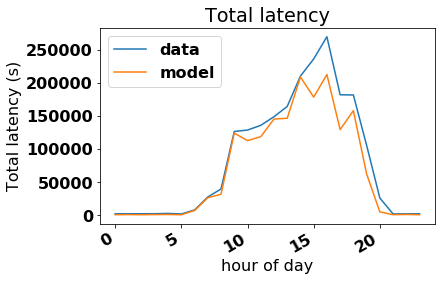

In [99]:
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib as matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

fig, ax = plt.subplots()
ax.plot(model_output['hours'], model_output['total_latency'], label='data')
ax.plot(model_output['hours'], model_output['total_latency_model'], label='model')


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Total latency (s)')
plt.xlabel('hour of day')
plt.title('Total latency')
plt.legend(loc='upper left')
plt.show()

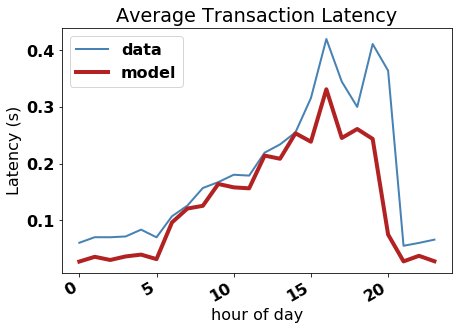

In [101]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(model_output['hours'], model_output['avg_latency'], color='steelblue', linewidth=2.0, label='data')
ax.plot(model_output['hours'], model_output['avg_latency_model'], color='firebrick', linewidth=4.0, label='model')


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Transaction Latency')
plt.legend(loc='upper left')
fig.savefig('Average_transaction_latency_hours_day1.png')

How does this compare to randomly assigning servers? Even though this is how it is already done in the dataset, we 're-assign' servers to a subset of apps (the same number we assigned to in our model) so we can have the opporutnity to get 0 duration.

## Same analysis but subset the data for training and testing

use the first 5 days for training, and the last 2 days for testing. Even though this covers weekends, which are in the training dataset, because of the relatively small amount of transactions on the weekend, it is not likely to skew the results.

In [8]:
train_df=df[df['Date']<'2017-08-08'] #first 6 days
test_df=df[df['Date']>'2017-08-08'] #last day

In [9]:
#adjust the min threshold to 0.9 instead of 0.8 percentile
confidence=0.7
percentile=0.9
apps_server=20
server_df_list_test90, server_assign90, model_output_test90, total_latency90, total_model_latency90, avg_latency90, avg_model_latency90=hourly_step_test_output(df_train=train_df, df_test=test_df, percentile=.9, confidence=confidence, apps_server=apps_server)

/home/ubuntu/notebook/Manifold/hourly_step_assign_test2.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=None
/home/ubuntu/notebook/Manifold/hourly_step_assign_test2.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=pd.DatetimeIndex(df_train['Date']).hour


In [10]:
total_latency90

506250.077

In [11]:
total_model_latency90

481288.119

In [12]:
model_reduction=(total_latency90-total_model_latency90)/total_latency90
model_reduction

0.049307563858405075

In [ ]:
#how many apps were assigned to specific servers for each timestep?

In [111]:
#for i in server_assign90:
#   print(len(i))

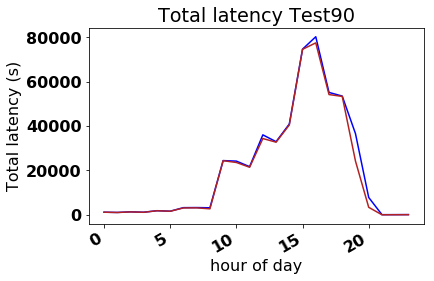

In [87]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

fig, ax = plt.subplots()
ax.plot(model_output_test90['hours'], model_output_test90['total_latency'], color='blue')
ax.plot(model_output_test90['hours'], model_output_test90['total_latency_model'], color='firebrick')


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Total latency (s)')
plt.xlabel('hour of day')
plt.title('Total latency Test90')
plt.show()

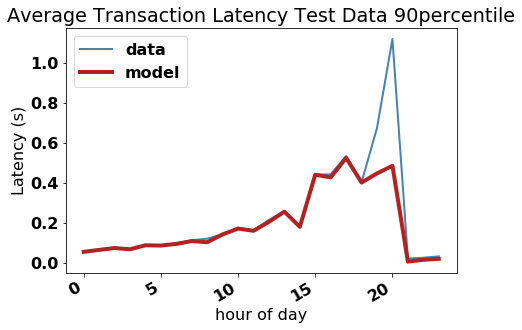

In [102]:
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(model_output_test90['hours'], model_output_test90['avg_latency'], color='steelblue', linewidth=2.0, label='data')
ax.plot(model_output_test90['hours'], model_output_test90['avg_latency_model'], color='firebrick', linewidth=4.0, label='model')


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Transaction Latency Test Data 90percentile')
plt.legend(loc='upper left')
fig.savefig('Average_transaction_latency_hours_day_Test_90.png')

## How does this compare to randomly assigning servers?

Figure out how many IPs were assigned based on our model, then randomly assign servers to the same amount of IPs

In [163]:
server_df_list_test90_rnd=[]
for i in server_df_list_test90:
    i['Src_IP']=i['Src_IP'].astype('str')
    i['Dst_IP']=i['Dst_IP'].astype('str')
    #number of IPs assigned
    num_srcIPs_assign=i['Src_IP'][i['Src_Server'].notna()].nunique()
    num_dstIPs_assign=i['Src_IP'][i['Dst_Server'].notna()].nunique()
    
    unique_Src_IPs=i['Src_IP'].drop_duplicates()
    unique_dst_IPs=i['Src_IP'].drop_duplicates()
    
    selected_src_IP=np.random.choice(unique_Src_IPs, num_srcIPs_assign)
    selected_dst_IP=np.random.choice(unique_dst_IPs, num_srcIPs_assign)
    
    rnd_server_df=pd.DataFrame({'Src_IP': selected_src_IPs, 'Src_server_rnd': None, 'Dst_IP': selected_dst_IPs, 'Dst_server_rnd': None} )
    num_servers_needed=len(rnd_server_df)/apps_server
    
    x = range(int(num_servers_needed))
    xx=np.repeat(x, 20) #assign servers
    
    rnd_server_df['Src_server_rnd']=xx
    rnd_server_df['Dst_server_rnd']=xx
    
    newdf=i.merge(rnd_server_df[['Src_IP', 'Src_server_rnd']], left_on='Src_IP', right_on='Src_IP', how='left')
    newdf=newdf.merge(rnd_server_df[['Dst_IP', 'Dst_server_rnd']], left_on='Dst_IP', right_on='Dst_IP', how='left')
    
    newdf['duration_rnd']=newdf['Duration']
    newdf.loc[newdf['Src_server_rnd']==newdf['Dst_server_rnd'], 'duration_rnd']=0#if random servers match, set latency time=0
    server_df_list_test90_rnd.append(newdf)


In [164]:
server_df_list_test90_rnd[0]

,Date,Duration,Src_IP,Src_pt,Dst_IP,Dst_pt,Packets,Bytes,date_hr,pairs,pairs2,norm_latency,hour,Src_Server,Dst_Server,duration_pred,Src_server_rnd,Dst_server_rnd,duration_rnd
0,2017-08-08 00:00:00.760,0.144,10692_129,443,192.168.210.54,52204.0,3,936,2017-08-08 00:00:00,"[10692_129, 192.168.210.54]","(10692_129, 192.168.210.54)",0.0480,0,NaN,NaN,0.144,NaN,NaN,0.144
1,2017-08-08 00:00:00.746,0.158,192.168.210.54,52204,10692_129,443.0,2,334,2017-08-08 00:00:00,"[10692_129, 192.168.210.54]","(10692_129, 192.168.210.54)",0.0790,0,NaN,NaN,0.158,NaN,NaN,0.158
2,2017-08-08 00:00:02.205,0.000,11948_124,80,192.168.220.51,40971.0,1,279,2017-08-08 00:00:00,"[11948_124, 192.168.220.51]","(11948_124, 192.168.220.51)",0.0000,0,NaN,NaN,0.000,NaN,NaN,0.000
3,2017-08-08 00:00:02.126,0.023,DNS,53,192.168.220.51,54811.0,2,371,2017-08-08 00:00:00,"[192.168.220.51, DNS]","(192.168.220.51, DNS)",0.0115,0,NaN,NaN,0.023,NaN,NaN,0.023
4,2017-08-08 00:00:02.098,0.031,192.168.220.51,54811,DNS,53.0,2,156,2017-08-08 00:00:00,"[192.168.220.51, DNS]","(192.168.220.51, DNS)",0.0155,0,NaN,NaN,0.031,NaN,NaN,0.031
5,2017-08-08 00:00:02.098,0.107,192.168.220.51,40971,11948_124,80.0,2,945,2017-08-08 00:00:00,"[11948_124, 192.168.220.51]","(11948_124, 192.168.220.51)",0.0535,0,NaN,NaN,0.107,NaN,0.0,0.107
6,2017-08-08 00:00:03.420,0.000,10027_194,80,192.168.220.51,40963.0,1,66,2017-08-08 00:00:00,"[10027_194, 192.168.220.51]","(10027_194, 192.168.220.51)",0.0000,0,NaN,NaN,0.000,NaN,NaN,0.000
7,2017-08-08 00:00:03.485,0.000,11930_163,80,192.168.220.51,38596.0,1,66,2017-08-08 00:00:00,"[11930_163, 192.168.220.51]","(11930_163, 192.168.220.51)",0.0000,0,NaN,NaN,0.000,NaN,NaN,0.000
8,2017-08-08 00:00:03.450,0.000,10763_18,443,192.168.220.51,43138.0,1,66,2017-08-08 00:00:00,"[10763_18, 192.168.220.51]","(10763_18, 192.168.220.51)",0.0000,0,NaN,NaN,0.000,NaN,NaN,0.000
9,2017-08-08 00:00:03.403,0.000,192.168.220.51,40963,10027_194,80.0,1,66,2017-08-08 00:00:00,"[10027_194, 192.168.220.51]","(10027_194, 192.168.220.51)",0.0000,0,NaN,NaN,0.000,NaN,NaN,0.000


In [166]:
total_rnd_latency_hour=[]
total_latency_hour=[]
total_latency_model_hour=[]
avg_rnd=[]
avg_latency_list=[]
avg_model=[]

for i in server_df_list_test90_rnd:
    total_latency=i['Duration'].sum()
    total_latency_rnd=i['duration_rnd'].sum()
    total_latency_model=i['duration_pred'].sum()
    total_latency_hour.append(total_latency)
    total_rnd_latency_hour.append(total_latency_rnd)
    total_latency_model_hour.append(total_latency_model)
    avg_latency=i['Duration'].mean()
    avg_latency_rnd=i['duration_rnd'].mean()
    avg_latency_model=i['duration_pred'].mean()
    avg_rnd.append(avg_latency_rnd)
    avg_latency_list.append(avg_latency)
    avg_model.append(avg_latency_model)

Text(0.5, 1.0, 'Total Latency Test Data')

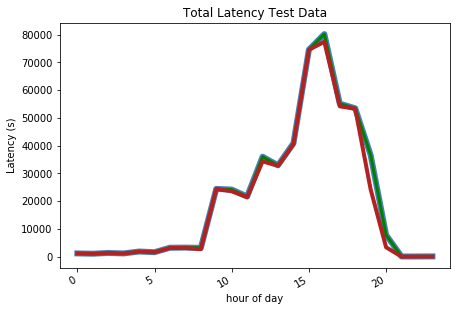

In [167]:
hour=range(0,24)
random_latency_df=pd.DataFrame({'hour':hour, 'total_latency': total_latency_hour, 'total_latency_rnd': total_rnd_latency_hour, 'total_model_latency': total_latency_model_hour, 'avg_latency':avg_latency_list, 'avg_rnd_latency':avg_rnd, 'avg_model_latency':avg_model})

fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(random_latency_df['hour'], random_latency_df['total_latency'], color='steelblue', linewidth=6.0)
ax.plot(random_latency_df['hour'], random_latency_df['total_latency_rnd'], color='green', linewidth=3.0)
ax.plot(random_latency_df['hour'], random_latency_df['total_model_latency'], color='firebrick', linewidth=4.0)


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Total Latency Test Data')

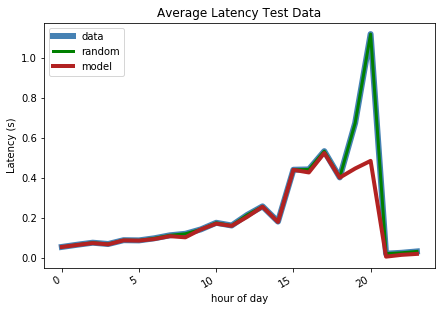

In [168]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(random_latency_df['hour'], random_latency_df['avg_latency'], color='steelblue', linewidth=6.0, label='data')
ax.plot(random_latency_df['hour'], random_latency_df['avg_rnd_latency'], color='green', linewidth=3.0, label='random')
ax.plot(random_latency_df['hour'], random_latency_df['avg_model_latency'], color='firebrick', linewidth=4.0, label='model')


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Latency Test Data')
plt.legend(loc='upper left')

Random assignment improved overall latency by:

In [169]:
random_reduction=(random_latency_df['total_latency'].sum()-random_latency_df['total_latency_rnd'].sum())/random_latency_df['total_latency'].sum()

In [170]:
random_reduction

0.0004070787792607546

In [171]:
latency_matrix=pd.DataFrame([random_reduction, model_reduction], ['Random Assignment', 'FP Model'])

In [172]:
latency_matrix

,0
Random Assignment,0.000407
FP Model,0.049308


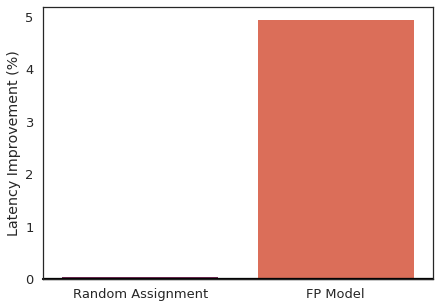

In [177]:
import seaborn as sns
sns.set(style="white", context="talk")
rs = np.random.RandomState(8)

# Set up the matplotlib figure
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

sns.barplot(x=latency_matrix.index, y=latency_matrix[0]*100, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Latency Improvement (%)")
fig.savefig('Latency_Improvement_hourly_model_test_bar.png')

### Repeat with a different min threshold, at a lower value we will create more rules.

### Set min support to 80th percentile (lower than 90th above)

In [56]:
server_df_list_test80, server_assign80, model_output_test, total_latency, total_model_latency, avg_latency, avg_model_latency=hourly_step_test_output(df_train=train_df, df_test=test_df, percentile=percentile, confidence=confidence, apps_server=apps_server)

/home/ubuntu/notebook/Manifold/hourly_step_test5.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=None
/home/ubuntu/notebook/Manifold/hourly_step_test5.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=pd.DatetimeIndex(df_train['Date']).hour


In [105]:
#for i in server_assign80:
    #print(len(i))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


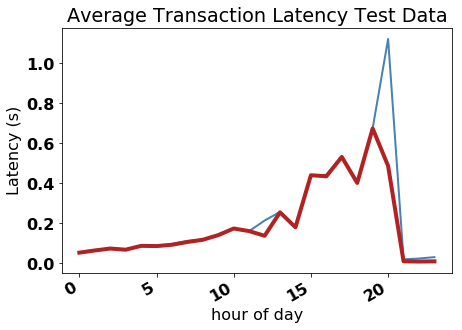

In [15]:
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(model_output_test['hours'], model_output_test['avg_latency'], color='steelblue', linewidth=2.0, label='data')
ax.plot(model_output_test['hours'], model_output_test['avg_latency_model'], color='firebrick', linewidth=4.0, label='model')


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Transaction Latency Test Data 80th percentile')
fig.savefig('Average_transaction_latency_hours_day_Test_80thper.png')

### Adjust min support to 40th percentile

In [106]:
#adjust the min threshold to 0.4 instead of 0.8 percentile
server_df_list_test40, server_assign40, model_output_test40, total_latency40, total_model_latency40, avg_latency40, avg_model_latency40=hourly_step_test_output(df_train=train_df, df_test=test_df, percentile=.4, confidence=confidence, apps_server=apps_server)

/home/ubuntu/notebook/Manifold/hourly_step_assign_test2.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=None
/home/ubuntu/notebook/Manifold/hourly_step_assign_test2.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=pd.DatetimeIndex(df_train['Date']).hour


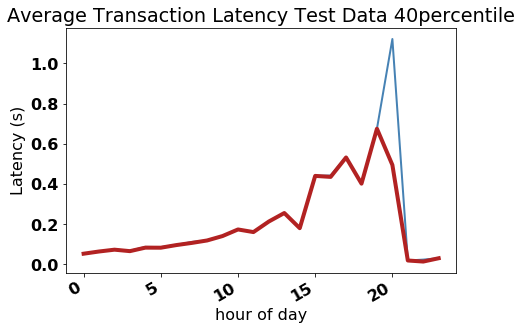

In [18]:
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(model_output_test40['hours'], model_output_test40['avg_latency'], color='steelblue', linewidth=2.0)
ax.plot(model_output_test40['hours'], model_output_test40['avg_latency_model'], color='firebrick', linewidth=4.0)


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Transaction Latency Test Data 40percentile')
fig.savefig('Average_transaction_latency_hours_day_Test_40.png')

I thought a higher percentile threshold, 90th instead of 40th would produce less rules, and lead to the model performing worse. Instead, we get a very big dip at the 90th percentile, and the 40th percentile does not do better. This is because when we lower the threshold and allow more rules to be created, this means we have more IPs to assign to more servers. Thus, important IPs pairs that may also share IPs in common are less likely to be on the same server. When we have more apps that pass the threshold, now the latency ranking can affect where they get scheduled, as the highest ranked ones get scheduled first. This ranking is related to frequency (frequency * duration), but if an app has a very high duration it will get scheduled before an app that occurs more frequentlyl.

Change the confidence value from 0.7 to 0.4

In [62]:
confidence4=0.4
#adjust the min threshold to 0.9 instead of 0.8 percentile
server_assign90_con4, model_output_test90_con4, total_latency90_con4, total_model_latency90_con4, avg_latency90_con4, avg_model_latency90_con4=hourly_step_test_output(df_train=train_df, df_test=test_df, percentile=.9, confidence=confidence4, apps_server=apps_server)

/home/ubuntu/notebook/Manifold/hourly_step_test5.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=None
/home/ubuntu/notebook/Manifold/hourly_step_test5.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=pd.DatetimeIndex(df_train['Date']).hour


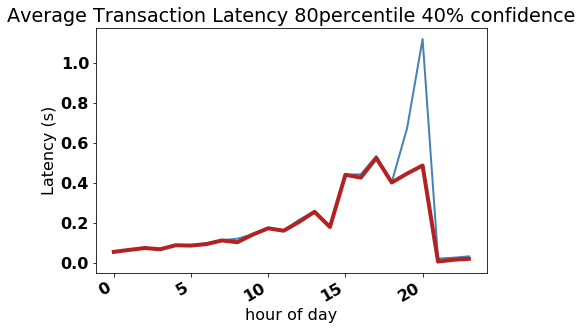

In [64]:
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(model_output_test90_con4['hours'], model_output_test90_con4['avg_latency'], color='steelblue', linewidth=2.0)
ax.plot(model_output_test90_con4['hours'], model_output_test90_con4['avg_latency_model'], color='firebrick', linewidth=4.0)


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Transaction Latency 80percentile 40% confidence')
fig.savefig('Average_transaction_latency_hours_day_Test_80_40con.png')

In [ ]:
## Try other training data strategy, where we use the first 3 days(Wed-Friday) and predict the next Monday, we want to avoid weekends.

In [74]:
train_df2=df[df['Date']<'2017-08-04'] #first2 days Wed-Fri
test_df2=df[(df['Date']>='2017-08-04') & (df['Date']<'2017-08-05')] #Monday

In [ ]:
#adjust the min threshold to 0.4 instead of 0.8 percentile with this 2nd training data
server_assign80_2,model_output_test80_2, total_latency80_2, total_model_latency80_2, avg_latency80_2, avg_model_latency80_2=hourly_step_test_output(df_train=train_df2, df_test=test_df2, percentile=.8, confidence=confidence, apps_server=apps_server)

/home/ubuntu/notebook/Manifold/hourly_step_test5.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=None
/home/ubuntu/notebook/Manifold/hourly_step_test5.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_train['hour']=pd.DatetimeIndex(df_train['Date']).hour


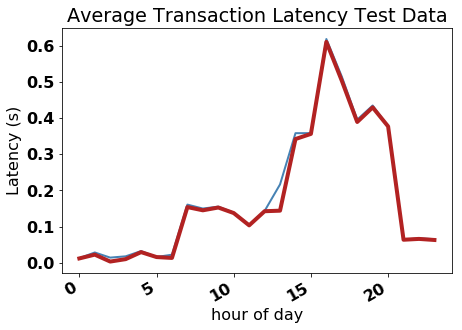

In [73]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(model_output_test80_2['hours'], model_output_test80_2['avg_latency'], color='steelblue', linewidth=2.0)
ax.plot(model_output_test80_2['hours'], model_output_test80_2['avg_latency_model'], color='firebrick', linewidth=4.0)


## Rotate date labels automatically
fig.autofmt_xdate()
plt.ylabel('Latency (s)')
plt.xlabel('hour of day')
plt.title('Average Transaction Latency Test Data')
fig.savefig('Average_transaction_latency_hours_80th_test2.png')